# Linear regression baseline

In this notebook, we will create the linear regression baselines.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm

In [47]:
import json

with open('/home/scratch/rohans2/gnn_saved/gnn_lead6h_epochs100_results.json', 'r') as f:
    print(json.loads(f))

FileNotFoundError: [Errno 2] No such file or directory: '/home/scratch/rohans2/gnn_saved/gnn_lead6h_epochs100_results.json'

In [2]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

## Load and prepare data for training

First up, we need to load and prepare the data so that we can feed it into our linear regression model.

In [3]:
DATADIR = '/home/scratch/rohans2/pgm_project/data/weatherbench/era5/2.8125/'
PREDDIR = '/home/scratch/rohans2/pgm_project/baselines/'
# DATADIR = '/data/stephan/WeatherBench/5.625deg/'
# PREDDIR = '/data/stephan/WeatherBench/baselines/'

In [4]:
# Load the entire dataset for the relevant variables
z500 = xr.open_mfdataset(f'{DATADIR}/geopotential/*.nc', combine='by_coords').z.sel(level=500).drop('level')
t850 = xr.open_mfdataset(f'{DATADIR}/temperature/*.nc', combine='by_coords').t.sel(level=850).drop('level')
data = xr.merge([z500, t850])

In [85]:
data

<xarray.Dataset>
Dimensions:  (lon: 128, lat: 64, time: 350627)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * time     (time) datetime64[ns] 1979-01-01T13:00:00 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8747, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8747, 64, 128), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [98]:
data.isel(time=0+72).z.values.shape

(64, 128)

In [96]:
data.isel(time=0).values()

ValuesView(<xarray.Dataset>
Dimensions:  (lon: 128, lat: 64)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
    time     datetime64[ns] 1979-01-01T13:00:00
Data variables:
    z        (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>
    t        (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential)

In [58]:
dv = data[list(data.keys())]

In [59]:
dv

<xarray.Dataset>
Dimensions:  (time: 350627, lat: 64, lon: 128)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * time     (time) datetime64[ns] 1979-01-01T13:00:00 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8747, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8747, 64, 128), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [62]:
df = dv.to_dataframe().reset_index()

In [121]:
dates = dv.time.values
dates

array(['1979-01-01T13:00:00.000000000', '1979-01-01T14:00:00.000000000',
       '1979-01-01T15:00:00.000000000', ...,
       '2018-12-31T21:00:00.000000000', '2018-12-31T22:00:00.000000000',
       '2018-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [129]:
np.cos(2 * np.pi * np.floor([(dt - np.datetime64(dt, 'Y'))/np.timedelta64(1, 'D') for dt in dates])/365)

array([1.        , 1.        , 1.        , ..., 0.99985184, 0.99985184,
       0.99985184])

In [130]:
np.sin(2 * np.pi * np.floor([(dt - np.datetime64(dt, 'Y'))/np.timedelta64(1, 'D') for dt in dates])/365)

array([ 0.        ,  0.        ,  0.        , ..., -0.01721336,
       -0.01721336, -0.01721336])

In [54]:
df = dv.to_dataframe(name=list(data.keys())[0]).reset_index()

In [109]:
(dv.time.values[0] - np.datetime64(dv.time.values[0], 'Y'))// np.timedelta64(1, 'D')

0

In [120]:
dv.time.values - np.datetime_as_string(dv.time, unit='Y')

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('<U22')

In [115]:
dates = np.array(['2023-04-26', '2022-11-15', '2024-01-01'], dtype='datetime64')
np.array([np.datetime_as_string(date, unit='D', format='%Y') for date in dates], dtype=int)

TypeError: datetime_as_string() got an unexpected keyword argument 'format'

In [108]:
dv.time.values[0]

numpy.datetime64('1979-01-01T13:00:00.000000000')

In [100]:
x = np.datetime64('2023-04-26') - np.datetime64('2023-03-26')
for att in dir(x):
    print('{}: {}'.format(att, getattr(x, att)))

T: 31 days
__abs__: <method-wrapper '__abs__' of numpy.timedelta64 object at 0x7f4302398f10>
__add__: <method-wrapper '__add__' of numpy.timedelta64 object at 0x7f4302398f10>
__and__: <method-wrapper '__and__' of numpy.timedelta64 object at 0x7f4302398f10>
__array__: <built-in method __array__ of numpy.timedelta64 object at 0x7f4302398f10>
__array_interface__: {'data': (94823999577408, False), 'strides': None, 'descr': [('', '<m8[D]')], 'typestr': '<m8[D]', 'shape': (), 'version': 3, '__ref': array(31, dtype='timedelta64[D]')}
__array_priority__: -1000000.0
__array_struct__: <capsule object NULL at 0x7f430221c2d0>
__array_wrap__: <built-in method __array_wrap__ of numpy.timedelta64 object at 0x7f4302398f10>
__bool__: <method-wrapper '__bool__' of numpy.timedelta64 object at 0x7f4302398f10>
__class__: <class 'numpy.timedelta64'>
__class_getitem__: <built-in method __class_getitem__ of type object at 0x7f43547cda00>
__copy__: <built-in method __copy__ of numpy.timedelta64 object at 0x7f4

In [63]:
len(df)

2872336384

In [55]:
len(df)

2872336384

In [64]:
df

,time,lat,lon,z,t
0,1979-01-01 13:00:00,-88.59375,0.0000,51432.789062,259.954346
1,1979-01-01 13:00:00,-88.59375,2.8125,51439.343750,260.015991
2,1979-01-01 13:00:00,-88.59375,5.6250,51449.171875,260.073090
3,1979-01-01 13:00:00,-88.59375,8.4375,51455.726562,260.121033
4,1979-01-01 13:00:00,-88.59375,11.2500,51465.558594,260.155273
...,...,...,...,...,...
2872336379,2018-12-31 23:00:00,88.59375,345.9375,48654.812500,249.865616
2872336380,2018-12-31 23:00:00,88.59375,348.7500,48635.113281,249.939880
2872336381,2018-12-31 23:00:00,88.59375,351.5625,48615.410156,250.011902
2872336382,2018-12-31 23:00:00,88.59375,354.3750,48595.710938,250.083908


In [65]:
df.to_pickle("/home/scratch/rohans2/all_data.pkl")

In [72]:
len(data.time)

350627

In [73]:
len(data.lon)

128

In [74]:
len(data.lat)

64

In [81]:
df.head()[['z', 't']].to_numpy().reshape((1, 5, 1, -1))

array([[[[51432.79   ,   259.95435]],

        [[51439.344  ,   260.016  ]],

        [[51449.17   ,   260.0731 ]],

        [[51455.727  ,   260.12103]],

        [[51465.56   ,   260.15527]]]], dtype=float32)

In [84]:
with open('/home/scratch/rohans2/all_data_4d_np.npy', 'wb') as f:
    np.save(f, df[['z', 't']].to_numpy().reshape((len(data.time), len(data.lat), len(data.lon), -1)))

In [75]:
df.head()

,time,lat,lon,z,t
0,1979-01-01 13:00:00,-88.59375,0.0000,51432.789062,259.954346
1,1979-01-01 13:00:00,-88.59375,2.8125,51439.343750,260.015991
2,1979-01-01 13:00:00,-88.59375,5.6250,51449.171875,260.073090
3,1979-01-01 13:00:00,-88.59375,8.4375,51455.726562,260.121033
4,1979-01-01 13:00:00,-88.59375,11.2500,51465.558594,260.155273


In [70]:
df.iloc[64*128-1]

time    1979-01-01 13:00:00
lat                88.59375
lon                357.1875
z              50734.839844
t                248.661316
Name: 8191, dtype: object

In [69]:
df.iloc[64*128]

time    1979-01-01 14:00:00
lat               -88.59375
lon                     0.0
z              51409.851562
t                260.084503
Name: 8192, dtype: object

In [11]:
z500.to_netcdf('/home/scratch/rohans2/pgm_project/data/weatherbench/era5/2.8125/processed/geopotential/geopotential_500.nc')
print("Dumped z500")
t850.to_netcdf('/home/scratch/rohans2/pgm_project/data/weatherbench/era5/2.8125/processed/temperature/temperature_850.nc')
print("Dumped t850")

KeyboardInterrupt: 

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

In [12]:
# Load the validation subset of the data: 2017 and 2018
z500_test = load_test_data(f'{DATADIR}geopotential', 'z')
t850_test = load_test_data(f'{DATADIR}temperature', 't')
test_data = xr.merge([z500_test, t850_test])

In [13]:
data = data.isel(time=slice(7+6, None))

In [14]:
# Split into train and test data
# Yes, technically we should have a separate validation set but for LR this shouldn't matter.
data_train = data.sel(time=slice('1979', '2016'))
# data_train = data.sel(time=slice('2016', '2016'))
data_test = data.sel(time=slice('2017', '2018'))

In [15]:
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().load()

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 2:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 2:
  #000: H5A.c line 528 in H5Ao

In [11]:
data_mean

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float32 5.41e+04
    t        float32 274.4

In [12]:
data_std = data_train.isel(time=slice(0, None, 10000)).std().load()

In [13]:
# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

In [15]:
data_test

<xarray.Dataset>
Dimensions:  (lon: 128, lat: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 64, 128), meta=np.ndarray>

In [16]:
_, nlat, nlon = data_train.z.shape; nlat, nlon

(64, 128)

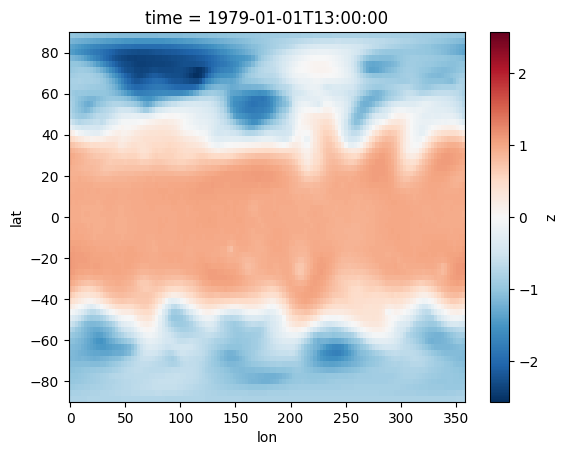

In [17]:
data_train.z.isel(time=0).plot()

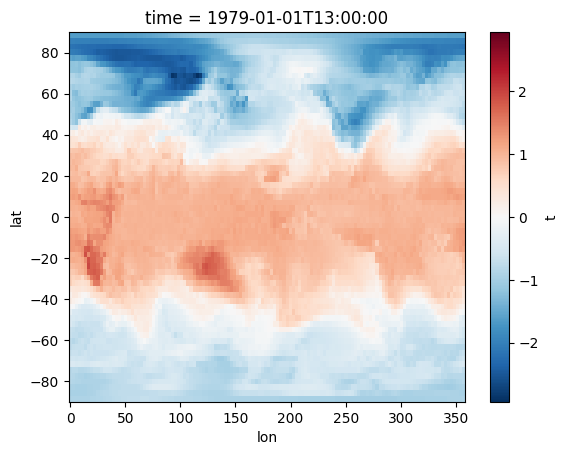

In [18]:
data_train.t.isel(time=0).plot()

In [19]:
data_train

<xarray.Dataset>
Dimensions:  (lon: 128, lat: 64, time: 333107)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * time     (time) datetime64[ns] 1979-01-01T13:00:00 ... 2016-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8747, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8747, 64, 128), meta=np.ndarray>

In [20]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

## Train linear regression

Now let's train the model. We will use scikit-learn for this.

In [21]:
def train_lr(lead_time_h, input_vars, output_vars, data_subsample=1):
    """Create data, train a linear regression and return the predictions."""
    X_train, y_train, X_test, y_test = [], [], [], []
    for v in input_vars:
        X, y = create_training_data(
            data_train[v],
            lead_time_h
        )
        
        X_train.append(X)
        if v in output_vars: y_train.append(y)
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        X_test.append(X)
        if v in output_vars: y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]
    
    X_train = X_train[::data_subsample]
    y_train = y_train[::data_subsample]
    
    lr = LinearRegression(n_jobs=16)
    lr.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(output_vars), nlat, nlon))
    
    fcs = []
    for i, v in enumerate(output_vars):
        fc = xr.DataArray(
            preds[:, i] * data_std[v].values + data_mean[v].values, 
            dims=['time', 'lat', 'lon'],
            coords={
                'time': valid_time,
                'lat': data_train.lat,
                'lon': data_train.lon
            },
            name=v
        )
        fcs.append(fc)
    return xr.merge(fcs), lr   

### 3 days

Here we train a model to directly predict the fields at 3 days lead time. Let's train a model that only predicts z or t and then a combined model. As we can see below, the model trained only on Z500 performs better than the combined model. But the same is not the case for T850. For the paper, we will use the combined model.

In [22]:
experiments = [
    [['z'], ['z']],
#     [['t'], ['t']],
#     [['z', 't'], ['z', 't']],
]

In [23]:
data_test

<xarray.Dataset>
Dimensions:  (lon: 128, lat: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 64, 128), meta=np.ndarray>

In [24]:
# Since training the LR on the full data takes up quite a lot of memory 
# we only take every 5th time step which gives almost the same results (<0.5% difference)
data_subsample = 5
lead_time = 3*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
    p.to_netcdf(f'{PREDDIR}/lr_3d_{"_".join(i)}_{"_".join(o)}.nc')
    to_pickle(m, f'{PREDDIR}/saved_models/lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')

0: Input variables = ['z']; output variables = ['z']


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Ao

As we can see the models with just the output variable as input almost always perform better because of overfitting. We could try a regularized regression like ridge of lasso but the point of these models not to be good but rather to provide a solid baseline with as few hyperparameters as possible.

In [28]:
# Same for 5 days
data_subsample = 5
lead_time = 5*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
    p.to_netcdf(f'{PREDDIR}/lr_5d_{"_".join(i)}_{"_".join(o)}.nc');
    to_pickle(m, f'{PREDDIR}/saved_models/lr_5d_{"_".join(i)}_{"_".join(o)}.pkl')

0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.05985911563038826
Test MSE = 0.07377636432647705
z = 783.048846860714

1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.048178404569625854
Test MSE = 0.06070050969719887
t = 3.439530277035071

2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 0.046257924288511276
Test MSE = 0.07199461758136749
z = 814.6603554764138; t = 3.5229546158256353

3: Input variables = ['tp']; output variables = ['tp']
Train MSE = 0.803996205329895
Test MSE = 1.062649130821228
tp = 0.00233752970513597

4: Input variables = ['z', 't', 'tp']; output variables = ['tp']
Train MSE = 0.6962897777557373
Test MSE = 1.172526478767395
tp = 0.0024531068049946053

5: Input variables = ['t2m']; output variables = ['t2m']
Train MSE = 0.018064960837364197
Test MSE = 0.023729275912046432
t2m = 2.604655216350416

6: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
Train MSE = 0.013758870773017406
Test MSE

### Iterative forecast

Finally, an iterative forecast. First, we train a model for 6 hours lead time and then construct an iterative forecast up to 120 hours.

In [22]:
def create_iterative_fc(state, model, lead_time_h=6, max_lead_time_h=5*24):
    max_fc_steps = max_lead_time_h // lead_time_h
    fcs_z500, fcs_t850 = [], []
    for fc_step in tqdm(range(max_fc_steps)):
        state = model.predict(state)
        fc_z500 = state[:, :nlat*nlon].copy() * data_std.z.values + data_mean.z.values
        fc_t850 = state[:, nlat*nlon:].copy() * data_std.t.values + data_mean.t.values
        fc_z500 = fc_z500.reshape((-1, nlat, nlon))
        fc_t850 = fc_t850.reshape((-1, nlat, nlon))
        fcs_z500.append(fc_z500); fcs_t850.append(fc_t850)

    return [xr.DataArray(
        np.array(fcs), 
        dims=['lead_time', 'time', 'lat', 'lon'],
        coords={
            'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
            'time': z500_test.time,
            'lat': z500_test.lat,
            'lon': z500_test.lon
        }
    ) for fcs in [fcs_z500, fcs_t850]]

In [31]:
p, m = train_lr(6, input_vars=['z', 't'], output_vars=['z', 't'], data_subsample=5)

Train MSE = 0.0033889012411236763
Test MSE = 0.0042942301370203495


In [33]:
to_pickle(m, f'{PREDDIR}/saved_models/lr_6h_z_t_z_t.pkl')

In [19]:
m = read_pickle(f'{PREDDIR}/saved_models/lr_6h_z_t_z_t.pkl')

/home/rasp/miniconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
state = np.concatenate([data_test.z.values.reshape(-1, nlat*nlon), 
                        data_test.t.values.reshape(-1, nlat*nlon)], 1)

In [23]:
fc_z500_6h_iter, fc_t850_6h_iter = create_iterative_fc(state, m)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [26]:
fc_iter = xr.Dataset({'z': fc_z500_6h_iter, 't': fc_t850_6h_iter})
fc_iter.to_netcdf(f'{PREDDIR}/lr_6h_iter.nc');

# The End